# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

from keras.models import Sequential
from keras.layers import Dense

# For TCLab
import tclab

# For itclab
import itclab

C:\Users\INDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize TCLab Emulator with 100x speedup for data collection

In [2]:
speedup = 100
TCLab = tclab.setup(connected=False, speedup = speedup)

### PID controller

In [3]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    if dt>=1e-8:
        dpv = (pv - pv_last) / dt
    else:
        dpv = 0.0;
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

### Generate data for training SVM

TCLab version 1.0.0
Simulated TCLab
TCLab Model disconnected successfully.


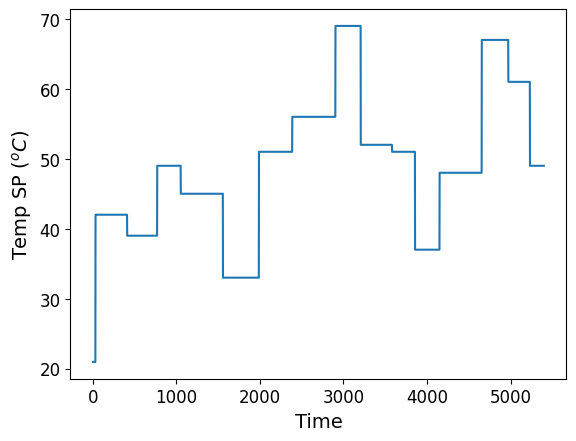

In [4]:
##### Set up run parameters #####
# Run time in minutes
run_time = 90.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with TCLab() as lab:
    Tsp1 = np.ones(loops) * lab.T1

# vary temperature setpoint
end = 30 # leave 1st 30 seconds of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600)
    Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

### Data Collection

In [5]:
# Data collection
with TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0
    
    prev_time = 0
    for i,t in enumerate(tclab.clock(loops-1)):
        tm[i] = t
        dt = t - prev_time
        
        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i])

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)
        
        # Calculate MPC output (optionally replace PID)

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        if i%100==0:
            print(('{:6.1f} {:6.2f} {:6.2f} ' + \
                  '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Tsp1[i],T1[i], \
                      Q1[i],P,ierr,D,iae))
        prev_time = t

TCLab version 1.0.0
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
   0.0  20.95  20.95   0.00   0.00   0.00  -0.00   0.00
 100.1  42.00  37.71  60.99  25.75  35.24  -0.00 943.77
 201.8  42.00  42.54  32.84  -3.26  36.10  -0.00 1049.80
 301.1  42.00  41.90  35.87   0.61  35.26  -0.00 1070.95
 401.1  42.00  42.22  34.00  -1.33  35.32  -0.00 1084.54
 506.0  39.00  38.68  29.11   1.94  27.16  -0.00 1197.06
 608.1  39.00  39.00  30.05   0.01  30.04  -0.00 1232.36
 708.1  39.00  39.00  30.11   0.01  30.10  -0.00 1233.17
 808.1  49.00  43.19  86.53  34.87  51.66  -0.00 1504.67
 908.0  49.00  50.60  43.13  -9.61  52.74  -0.00 1689.14
1008.1  49.00  48.99  47.11   0.06  47.05  -0.00 1760.42
1108.1  45.00  46.09  29.49  -6.53  36.03  -0.00 1899.19
1208.0  45.00  44.48  41.98   3.14  38.84  -0.00 1953.43
1308.0  45.00  45.12  39.51  -0.73  40.24  -0.00 1976.25
1408.0  45.00  44.80  41.47   1.20  40.27  -0.00 1991.50
1508.1  45.00  45.12  39.41  -0.73  40.15  -0.00 2006.28
1608.1

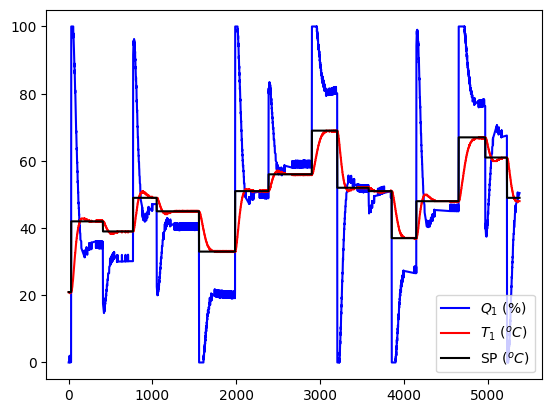

In [6]:
df = pd.DataFrame()
df['Q1'] = Q1[:i]
df['Q1'].fillna(0,inplace=True)
df['T1'] = T1[:i]
df['Tsp'] = Tsp1[:i]

# Plot
plt.plot(df['Q1'],'b-',label='$Q_1$ (%)')
plt.plot(df['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(df['Tsp'],'k-',label='SP $(^oC)$')
plt.legend()
plt.savefig('PID_train.png');

## Feature selection

In [7]:
# Create new feature: setpoint error
df['err'] = df['Tsp'] - df['T1']



In [8]:
df.to_csv('PID_train_data.csv',index=False)

# Load dataset, Scale data, Split into training and test sets

In [9]:
df = pd.read_csv('PID_train_data.csv')

In [17]:
X = df[['Tsp','err']].values
y = df[['Q1']].values
# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xs,ys,test_size=0.15,shuffle=False)

# Model Creation

### SVM Model

In [19]:
# import svm regression
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
model.fit(Xtrain,ytrain)

C:\Users\INDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

### Deep Learning Model

In [20]:
# Inisialisasi konstruktor
model_dl = Sequential()
# Tambahkan lapisan masukan
model_dl.add(Dense(2, activation='sigmoid', input_shape=(2,)))
# Tambahkan satu lapisan tersembunyi
model_dl.add(Dense(3, activation='sigmoid'))
# Tambahkan lapisan keluaran
model_dl.add(Dense(3, activation='sigmoid'))

# Data Latih.
X = np.array([
    [1, 1],
    [0.4, 1.2],
    [1.2, 0.1],
    [1, 0.1]
])

# Label untuk Data Latih.
y = np.array([
    [0.25, 4.31, 0.20],
    [0.2, 4.1, 0.1],
    [0.1, 4.0, 0],
    [0.1, 4.0, 0]
])

# Ringkasan model
model_dl.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
Total params: 27 (108.00 Byte)
Trainable params: 27 (108.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model_dl.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_dl.fit(X, y,epochs=100, batch_size=1, verbose=1)


Epoch 1/100


4/4 [==============================] - 1s 4ms/step - loss: 1.3423 - accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 541us/step - loss: 1.3252 - accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 1.3082 - accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 1.2915 - accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 0s/step - loss: 1.2748 - accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 535us/step - loss: 1.2580 - accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2415 - accuracy: 0.0000e+00
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2253 - accuracy: 0.0000e+00
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2089 - accuracy: 0.0000e+00
Epoch 10/100
4/4 [==============================] - 0s 0s/step - loss: 1.1927 - accur

### PID Deep Learning Controller

In [22]:
def pid_dl(sp,pv,pv_last,ierr,dt):

    # calculate the error
    error = sp-pv
    d_error = sp-pv_last
    delta_error = (error - d_error)

    outDL = model_dl.predict(np.array([[error,delta_error]]))

    Kc = outDL[0,0]
    tauI = outDL[0,1]
    tauD = outDL[0,2]

    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0

    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

### SVM PID Controller

In [74]:
def svm(T1_m, Tsp_m):
    # Calculate error (necessary feature for SVM input)
    err = Tsp_m - T1_m
    # Format data for SVM input
    X = np.array([[Tsp_m,err]])
    Xs = s_x.transform(X)
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    # make q_1c_s back from minmaxscaler
    
    Q_1 = s_y.inverse_transform([Q1c_s])
    Q1c = np.clip(Q_1,0.0,100.0)
    return Q1c

### Generate SP data for test

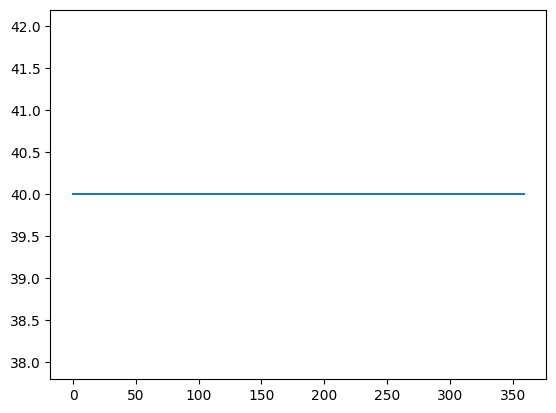

In [24]:
# Run time in minutes
run_time = 6.0

# Number of cycles
loops = int(60.0 * run_time)

# Arrays for storing data
T1 = np.zeros(loops)  # Measured T (degC)
tm = np.zeros(loops)  # Time
Tsp = np.zeros(loops)
# Set Tsp to 40°C for 5 minutes
Tsp[:300] = 40.0

# Leave the rest as the initial value (room temperature)
Tsp[300:] = Tsp[0]

plt.plot(Tsp)
plt.show()

In [25]:
def step_info(resp, t, set_point):
    """
    Calculates overshoot, settling time, and rising time of a step response.

    Parameters:
    - resp: numpy array, step response values
    - t: numpy array, time vector corresponding to the step response
    - set_point: float, the desired set point of the system
    """

    # Calculate overshoot
    max_resp = np.max(resp)
    overshoot = ((max_resp - set_point) / set_point) * 100

    # Calculate settling time
    within_range = np.where((resp >= set_point * 0.98) & (resp <= set_point * 1.02))[0]
    if len(within_range) > 0:
        settling_time = t[within_range[-1]] - t[within_range[0]]
    else:
        settling_time = np.inf

    # Calculate rising time
    first_crossing = np.where(resp >= set_point * 0.1)[0][0]
    last_crossing = np.where(resp >= set_point * 0.9)[0][0]
    rising_time = t[last_crossing] - t[first_crossing]

    # Print the results
    print("Overshoot: {:.2f}%".format(overshoot))
    print("Settling Time: {:.2f} seconds".format(settling_time))
    print("Rising Time: {:.2f} seconds".format(rising_time))
    return overshoot, settling_time, rising_time

# Testing With itclab

In [28]:
a = itclab.iTCLab()
a.LED(0)
print(a.T1)
a.close()

Opening connection
iTCLab connected via Arduino on port COM3
26.08
Arduino disconnected successfully


True

In [45]:
a = itclab.iTCLab()
print('LED On')
a.LED(100)

run_times =3
loops = int(60.0*run_times)
tm = np.zeros(loops)
T1 = np.zeros(loops)
Tsp = np.zeros(loops)
Q1 = np.zeros(loops)
# Set point to 40 all the time
Tsp[:] = 40

start_time = time.time()
prev_time = start_time
ierr = 0.0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in C
        T1[i] = a.T2

        [Q1[i],P,ierr,D] = pid(Tsp[i],T1[i],T1[i-1],ierr,dt)
        a.Q2(Q1[i])
        a.Q1(0.0)
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
               '{:6.2f} ').format( \
            tm[i],Tsp[i],T1[i], \
            Q1[i]))
        # 

except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()


# Make sure serial connection still closes when there's an error
except:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()

    raise

a.Q1(0.0)
a.Q2(0.0)
a.close()

Opening connection
iTCLab connected via Arduino on port COM3
LED On
   1.0  40.00  27.73  74.59 
   2.0  40.00  27.71  75.70 
   3.0  40.00  27.82  76.00 
   4.0  40.00  27.67  77.88 
   5.0  40.00  27.71  78.62 
   6.0  40.00  27.67  79.84 
   7.0  40.00  27.69  80.70 
   8.0  40.00  27.72  81.50 
   9.0  40.00  27.67  82.78 
   9.9  40.00  27.77  83.15 
  10.9  40.00  27.90  83.33 
  11.9  40.00  27.84  84.66 
  12.9  40.00  27.83  85.69 
  13.9  40.00  28.00  85.62 
  14.9  40.00  28.03  86.39 
  15.9  40.00  28.09  86.98 
  16.9  40.00  28.08  87.98 
  17.9  40.00  28.17  88.38 
  18.9  40.00  28.21  89.07 
  19.9  40.00  28.29  89.52 
  20.9  40.00  28.34  90.15 
  21.9  40.00  28.40  90.71 
  22.8  40.00  28.45  91.33 
  23.8  40.00  28.42  92.43 
  24.8  40.00  28.57  92.44 
  25.8  40.00  28.71  92.50 
  26.8  40.00  28.77  93.03 
  27.8  40.00  28.86  93.38 
  28.8  40.00  28.95  93.72 
  29.8  40.00  28.89  94.96 
  30.8  40.00  29.01  95.11 
  31.8  40.00  29.30  94.22 
  32

True

In [46]:
a.close()

Arduino disconnected successfully


True

In [47]:
[overshoot, settling_time, rise_time] = step_info(T1, tm, Tsp[0])

Overshoot: 6.42%
Settling Time: 27.82 seconds
Rising Time: 86.45 seconds


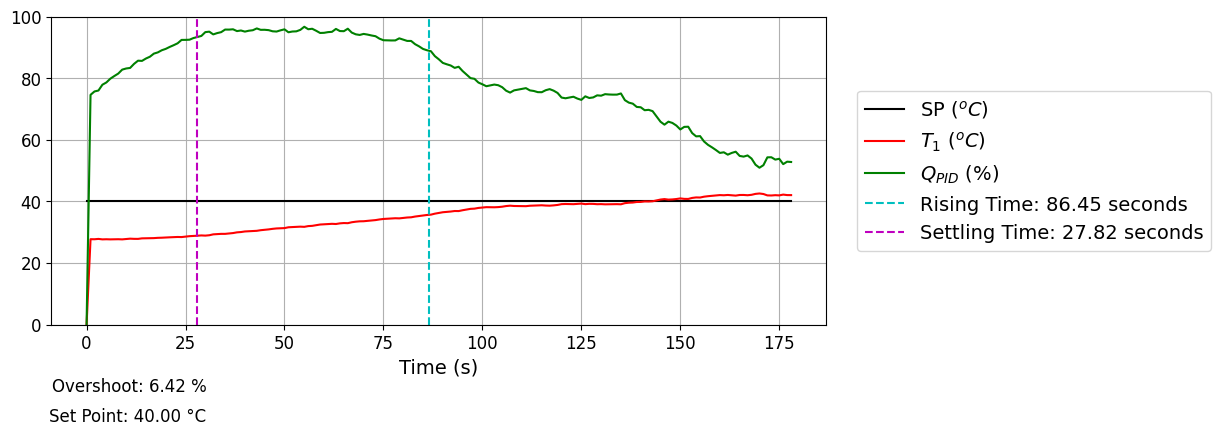

In [48]:
plt.figure(figsize=(10,4))
plt.plot(Tsp[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.plot(Q1[:i],'g-',label='$Q_{PID}$ (%)')
# Add overshoot label
plt.text(0.2, -0.2, 'Overshoot: {:.2f} %'.format(overshoot), ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)
# add set point label
plt.text(0.2, -0.3, 'Set Point: {:.2f} °C'.format(Tsp[0]), ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)


# Add rising time annotation
plt.axvline(x=rise_time, color='c', linestyle='--', label='Rising Time: {:.2f} seconds'.format(rise_time))
# add settling time annotation
plt.axvline(x=settling_time, color='m', linestyle='--', label='Settling Time: {:.2f} seconds'.format(settling_time))

plt.legend(fontsize=14, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

In [49]:
a.close()

Arduino disconnected successfully


True

In [ ]:
# stop for 3 minutes code
for i in range(1,3):
    print(i)
    time.sleep(60)

1
2
3
4


In [ ]:
a = itclab.iTCLab()
a.LED(0)
print(a.T1)
a.close()

Opening connection
iTCLab connected via Arduino on port COM5
30.29
Arduino disconnected successfully


True

In [50]:
a = itclab.iTCLab()
print('LED On')
a.LED(100)
run_times = 3
loops = int(60.0*run_times)
tm = np.zeros(loops)
T1 = np.zeros(loops)
Tsp = np.zeros(loops)
Q1 = np.zeros(loops)
# Set point to 40 all the time
Tsp[:] = 40

start_time = time.time()
prev_time = start_time
ierr = 0.0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in C
        T1[i] = a.T2

        [Q1[i],P,ierr,D] = pid_dl(Tsp[i],T1[i],T1[i-1],ierr,dt)

        a.Q2(Q1[i])
        a.Q1(0.0)
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
               '{:6.2f} ').format( \
            tm[i],Tsp[i],T1[i], \
            Q1[i]))

except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()


# Make sure serial connection still closes when there's an error
except:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()

    raise

a.close()

Opening connection
iTCLab connected via Arduino on port COM3
LED On
1/1 [==============================] - 0s 204ms/step
   1.0  40.00  27.83   6.91 
1/1 [==============================] - 0s 26ms/step
   2.0  40.00  27.81  14.28 
1/1 [==============================] - 0s 20ms/step
   3.0  40.00  27.80  19.74 
1/1 [==============================] - 0s 22ms/step
   4.0  40.00  27.88  25.10 
1/1 [==============================] - 0s 21ms/step
   5.0  40.00  27.74  30.64 
1/1 [==============================] - 0s 18ms/step
   6.0  40.00  27.81  36.04 
1/1 [==============================] - 0s 20ms/step
   7.0  40.00  27.80  41.48 
1/1 [==============================] - 0s 21ms/step
   7.9  40.00  27.84  46.88 
1/1 [==============================] - 0s 21ms/step
   8.9  40.00  27.72  52.45 
1/1 [==============================] - 0s 29ms/step
   9.9  40.00  27.86  57.84 
1/1 [==============================] - 0s 20ms/step
  10.9  40.00  27.78  63.35 
1/1 [==============================] - 0

True

In [51]:
a.close()
a = itclab.iTCLab()
a.LED(0)
a.close()

Arduino disconnected successfully
Opening connection
iTCLab connected via Arduino on port COM3
Arduino disconnected successfully


True

In [ ]:
a.close()

Arduino disconnected successfully


True

In [52]:
[overshoot, settling_time, rise_time] = step_info(T1, tm, Tsp[0])

Overshoot: 7.70%
Settling Time: 28.79 seconds
Rising Time: 89.45 seconds


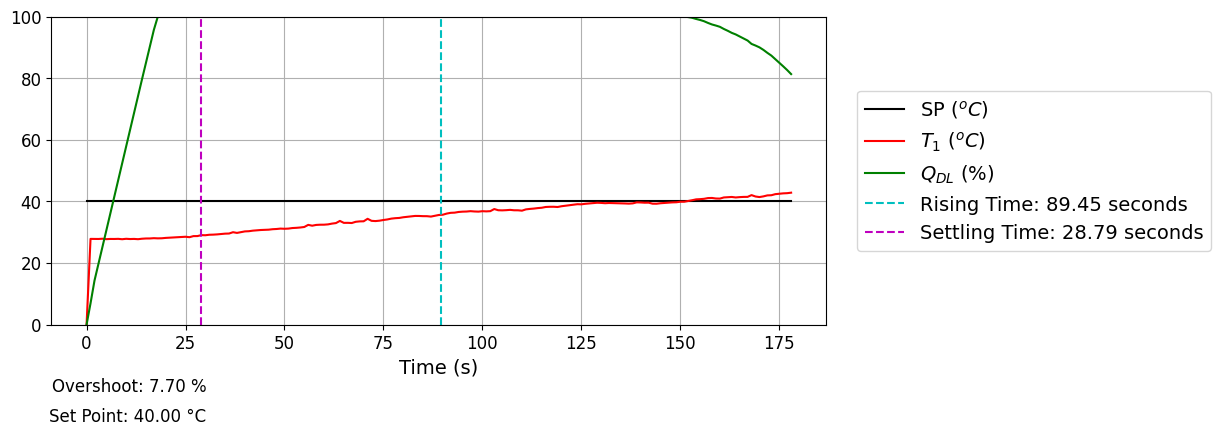

In [53]:
plt.figure(figsize=(10,4))
plt.plot(Tsp[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.plot(Q1[:i],'g-',label='$Q_{DL}$ (%)')
# Add overshoot label
plt.text(0.2, -0.2, 'Overshoot: {:.2f} %'.format(overshoot), ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)
# add set point label
plt.text(0.2, -0.3, 'Set Point: {:.2f} °C'.format(Tsp[0]), ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)


# Add rising time annotation
plt.axvline(x=rise_time, color='c', linestyle='--', label='Rising Time: {:.2f} seconds'.format(rise_time))
# add settling time annotation
plt.axvline(x=settling_time, color='m', linestyle='--', label='Settling Time: {:.2f} seconds'.format(settling_time))

plt.legend(fontsize=14, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

In [ ]:
a.close()
a = itclab.iTCLab()
print(a.T1)
a.LED(0)
a.close()

Arduino disconnected successfully
Opening connection
iTCLab connected via Arduino on port COM5
30.4
Arduino disconnected successfully


True

In [ ]:
# stop for 3 minutes code
for i in range(1,3):
    print(i)
    time.sleep(60)

1
2


In [75]:
a = itclab.iTCLab()
print('LED On')
a.LED(100)
run_times = 3
loops = int(60.0*run_times)
tm = np.zeros(loops)
T1 = np.zeros(loops)
Tsp = np.zeros(loops)
Q1 = np.zeros(loops)
# Set point to 40 all the time
Tsp[:] = 40

start_time = time.time()
prev_time = start_time
ierr = 0.0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in C
        T1[i] = a.T2
        Q1[i] = svm(T1[i],Tsp[i])
        a.Q2(Q1[i])
        a.Q1(0.0)
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
               '{:6.2f} ').format( \
            tm[i],Tsp[i],T1[i], \
            Q1[i]))

except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()


# Make sure serial connection still closes when there's an error
except:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()

    raise

a.close()

Opening connection
iTCLab connected via Arduino on port COM3
LED On
   1.0  40.00  25.97  86.39 
   2.0  40.00  25.96  86.42 
   3.0  40.00  25.91  86.58 
   4.0  40.00  26.03  86.20 
   5.0  40.00  26.06  86.10 
   6.0  40.00  25.99  86.32 
   7.0  40.00  26.57  84.46 
   8.0  40.00  26.11  85.94 
   9.0  40.00  26.15  85.81 
  10.0  40.00  26.18  85.72 
  11.0  40.00  26.27  85.43 
  11.9  40.00  26.22  85.59 
  12.9  40.00  26.27  85.43 
  13.9  40.00  26.33  85.24 
  14.9  40.00  26.37  85.11 
  15.9  40.00  26.45  84.85 
  16.9  40.00  26.41  84.98 
  17.9  40.00  26.50  84.69 
  18.9  40.00  26.66  84.17 
  19.9  40.00  26.74  83.91 
  20.9  40.00  26.67  84.14 
  21.9  40.00  26.89  83.43 
  22.9  40.00  27.07  82.84 
  23.9  40.00  27.04  82.94 
  24.9  40.00  27.18  82.48 
  25.9  40.00  27.27  82.19 
  26.9  40.00  27.37  81.86 
  27.9  40.00  27.42  81.70 
  28.9  40.00  27.59  81.14 
  29.9  40.00  27.68  80.84 
  30.9  40.00  27.68  80.84 
  31.9  40.00  27.88  80.18 
  32

True

In [76]:
a.close()

Arduino disconnected successfully


True

In [77]:
[overshoot, settling_time, rise_time] = step_info(T1, tm, Tsp[0])

Overshoot: 7.23%
Settling Time: 26.87 seconds
Rising Time: 101.59 seconds


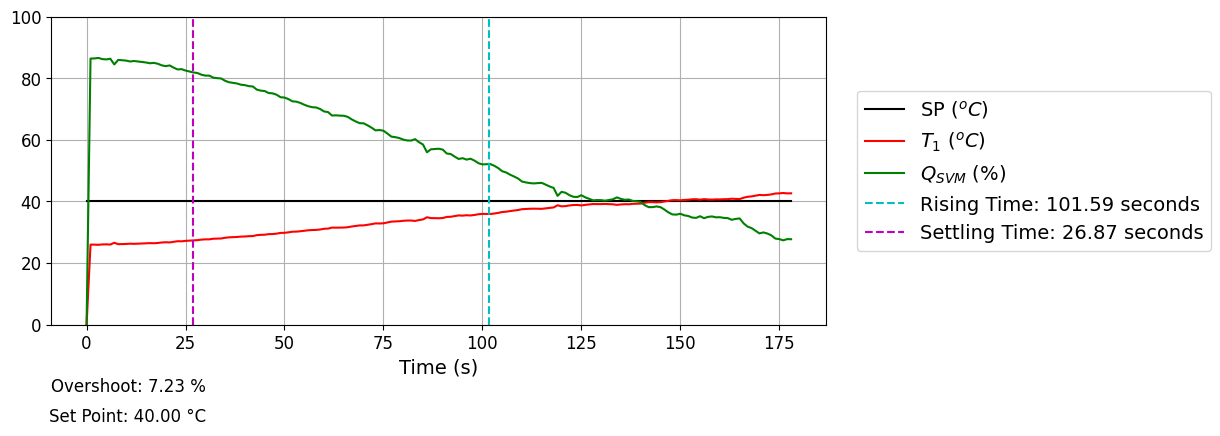

In [79]:
plt.figure(figsize=(10,4))
plt.plot(Tsp[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.plot(Q1[:i],'g-',label='$Q_{SVM}$ (%)')
# Add overshoot label
plt.text(0.2, -0.2, 'Overshoot: {:.2f} %'.format(overshoot), ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)
# add set point label
plt.text(0.2, -0.3, 'Set Point: {:.2f} °C'.format(Tsp[0]), ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)


# Add rising time annotation
plt.axvline(x=rise_time, color='c', linestyle='--', label='Rising Time: {:.2f} seconds'.format(rise_time))
# add settling time annotation
plt.axvline(x=settling_time, color='m', linestyle='--', label='Settling Time: {:.2f} seconds'.format(settling_time))

plt.legend(fontsize=14, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

In [80]:
# save model svm
import pickle
filename = 'svm_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [81]:
# save x and y scaler
filename = 'scaler_x.pkl'
pickle.dump(s_x, open(filename, 'wb'))
filename = 'scaler_y.pkl'
pickle.dump(s_y, open(filename, 'wb'))